### To explore various methods of reducing the issues brought upon by imbalanced datasets in ML problems

Learning phase and subsequent prediction of models can be affected by the problem of imbalanced datasets. More often than not, the decision function of classifiers would usually favour the majority class.

- Undersampling
- Oversampling

When to undersample/oversample?

- Undersample when dataset is huge and optimizing for recall: Models are trained on sparse actions (e.g. clickads), false negatives are worse than false positives. A side effect of reducing training cost


How should we rebalance dataset:
- Equal proportion of both classes?
- Majority stays represented?

No straight-forward answer as modifying datasets with resampling methods is changing reality.
Exercise with caution.

Evaluation methods

Accuracy based: classifier would as a matter of fact, always predict the majority class if real data is imbalanced.
Cost-based: 

In [39]:
# Packages
from collections import Counter
from sklearn.datasets import load_iris
from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression
from imblearn.datasets import make_imbalance
from imblearn.pipeline import make_pipeline as make_pipeline_imb
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd
import numpy as np

#### Loading in datasets

In [4]:
# # Iris
# iris_df = load_iris()
# x = iris_df.data
# y = iris_df.target

# # Check class
# Counter(y)

In [5]:
# Credit-card kaggle
cc_df = pd.read_csv("creditcard.csv")

In [6]:
# X: features
x_cc = cc_df.iloc[:,1:30]
x_cc = np.array(x_cc)

# Y: labels
y_cc = cc_df['Class'].values

In [7]:
# Check class
Counter(y_cc)

Counter({0: 284315, 1: 492})

In [8]:
str((492/284315)*100) + ' %'

'0.17304750013189596 %'

#### Creating imbalance

In [9]:
# Iris: Manually create an imbalanced dataset
# X, Y = make_imbalance(x, y, sampling_strategy={0: 24, 2: 50}, random_state=42)

#### Resampling Techniques

In [45]:
## Oversampling
from imblearn import over_sampling
## Undersampling
from imblearn import under_sampling

In [11]:
# Random over-sampling of minority class (naive)
## Duplicating some of the original samples of the minority class(Picking sample at random with replacement). Gives equal distribution of each class
pl_ros = make_pipeline_imb(
    over_sampling.RandomOverSampler(random_state=42),
    LogisticRegression(random_state=42))

In [12]:
# SMOTE: Synthetic Minority Oversampling Technique
pl_smote = make_pipeline_imb(
    over_sampling.SMOTE(random_state=42, sampling_strategy=0.5),
    LogisticRegression(random_state=42))

In [13]:
# ADASYN: Adaptive Synthetic sampling
pl_adasyn = make_pipeline_imb(
    over_sampling.ADASYN(random_state=42),
    LogisticRegression(random_state=42))

### Oversampling

#### SMOTE: Synthetic Minority Oversampling Technique
http://rikunert.com/SMOTE_explained

- Synthesises new instances at some distance from them towards one/some of their neighbours (think k-nearest neighbours). 
- The minority instances to oversample is randomly chosen. This could lead to within-class imbalance where Input areas counting many minoritysamples have a high probability of being inflated further, while sparsely populated minority areas are likely to remain sparse.
- Noise could be generated as it doesn't distinguish "danger" and "safe" regions when generate instances.

At K = 1, only the closest neighbour of the same class is considered.


At K = 2, 2 of the closest neighbours are considered. A new instance is randomly generated between the neighbours.

_Parameters:_
- `sampling_strategy`:
    - `float`: desired ratio of (no. minority class/ no. majority class). Only for binary classification. e.g. 0.6
    - `str`: specify the class targeted by the resampling.
        - `minority`: resample only minority class
        - `not minority`: resample all classes except minority
        - `not majority`
        - `all`
        - `auto` = `not majority` [default]
        
    - `dict`: keys corresponds to targeted classes  
    
     
- `k_neighbours`: no. neighbours used to construct synthetic samples; default=5
- `random_state`

#### ADASYN: Adaptive Synthetic

Pretty much the same as SMOTE, key difference:
- uses a weighted distribution for different minority class examples according to their level of difficulty in learning, where more synthetic data is generated for minority class examples that are harder to learn compared to those minority examples that are easier to learn. SMOTE generates same number of synthetic data for each original minority class

- uses Euclidean distance for KNN algorithm, same as SMOTE

_Parameters same as SMOTE_

Both SMOTE and ADASYN uses the same algorithm to generate sample.  
A new sample x_new is generated by looking at the classes of the k-nearest-neighbours:
 
   $x_{new} = x_i + \lambda \times (x_{zi} - x_i)$ 
 
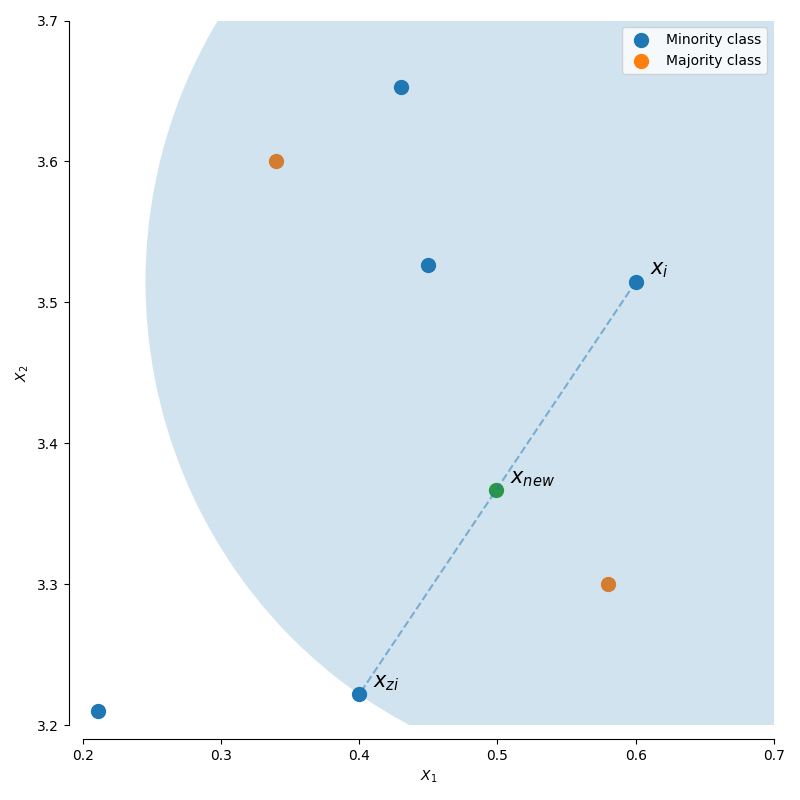

However:
https://www.kaggle.com/residentmario/oversampling-with-smote-and-adasyn
- SMOTE usually generate new samples by connecting inliers and outliers (as easily identified by "spaghetti-looking line constructed from a point to an outlier. This could be mistaken as a new feature by the model) This weakness could be alleviated via the SMOTE variants

- While ADASYN  may generate its sample by focusing soley on outliers (a.k.a not in homogenous neighbourhoods). 

Both cases could lead to sub-optimal decision functions.
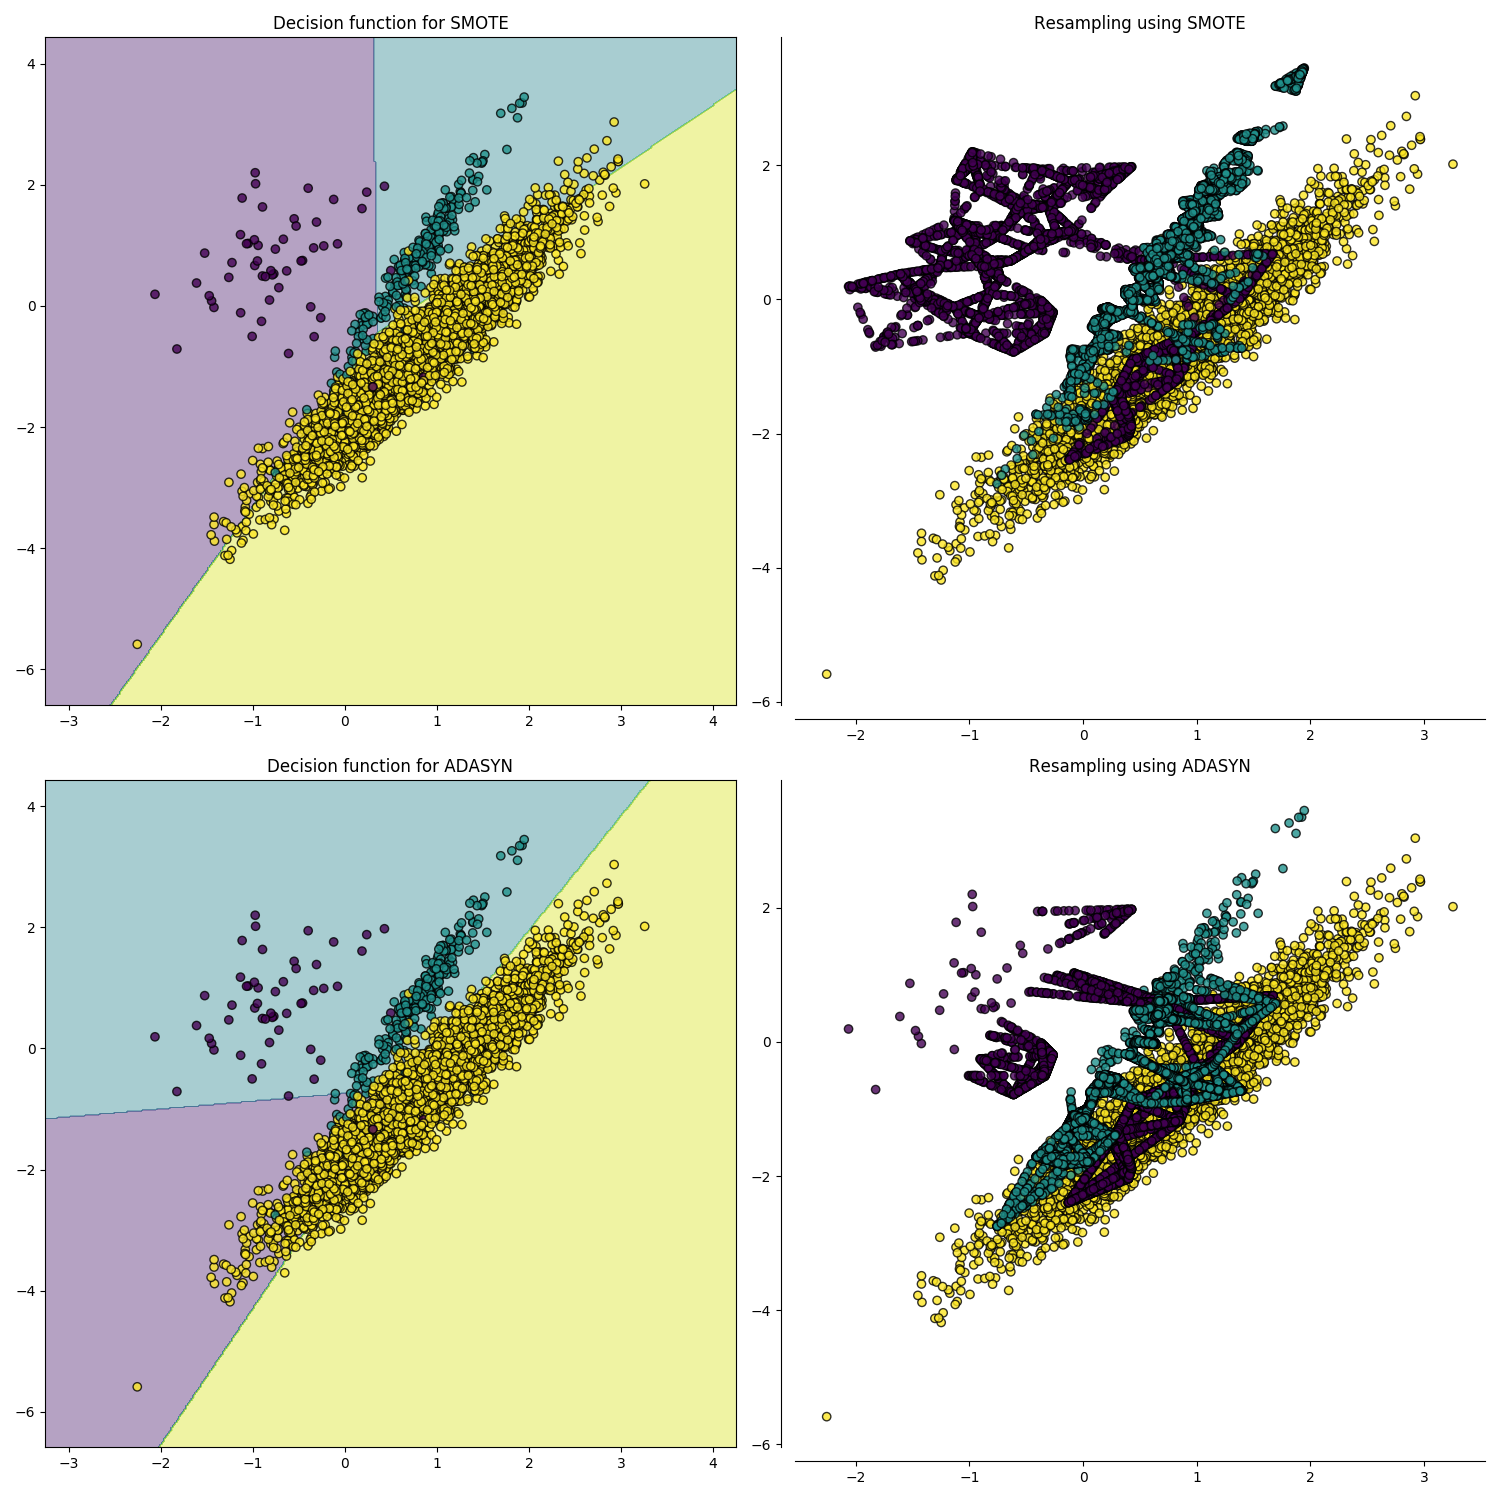

#### SMOTE variants

#### BorderlineSMOTE

Only sample points on the border, solves inlier-outlier join but results in densely populated borders. But clusters would usually still look linearly seperable without inlier-outlier line construts.

- Points are first classified into 
    - noise: all nearest neighbours are of different class
    - in danger: 50% or more nearest neighbours are of different class
    - safe: all nearest neighbours are of same class
- Next, only points in danger are sampled
- Lastly, instead of the default of selecting an instance from n_neighbours of the same class,
    - `boderline1`: selects instance from n nearest points not belonging to the given instance's class (given instance's class depends on `sampling_strategy`. [visuals are clustered borders]
    - `boderline2`: selects instance from n nearest points of any class [visuals are in-between borderline1 & regular SMOTE]
    
![image.png](attachment:image.png)


_Parameters_:
    
- `m_neighbours`: number of nearest neighbours to use to determine if a minority sample is in danger. 


#### SMOTE SVM

Uses SVM to approximate boderline area, generate minority instances around the borderline of decision function with its nearest neighbours by interpolation or extrapolation, depending on density of majority class at that area. Extrapolate if majority are dense, interpolate otherwise. 

_Parameters_:

- `svm_estimator`: `C` parameter in sklearn.svm.SVC() allows to select more or less support vectors. eg. sklearn.svm.SVC(C=1.0); float.   
    _C parameter tells the SVM optimization how much you want to avoid misclassifying each training example. Large values: smaller-margin hyperplane, less misclassification. Small values: larger-margin hyperplan, more misclassification._
    
- `m_neighbours`: number of nearest neighbours to use to determine if a minority sample is in danger. 

#### SMOTE Kmeans

Uses K-means to approximate clusters instead of KNN, then sample using nearest neighbours. This aims to reduce generation of noise by oversampling only in safe areas.

#### SMOTE-NC: SMOTE for Nominal and Continuous datapoints

Generalized to handle mixed datasets of nominal features; not full nominal, must have at least 1 column of continuous/discrete
- Compute the median of the std deviation of minority class to use in the Euclidean formula for KNN

_Parameters_:
- `categorical_features`: array of indices of categorical columns

 _The rest of the params are the same as SMOTE_

### Undersampling

#### (Prototype generation) Generates a new set $S'$ where $|S'| < |S|$ and $S' \not\in S$.

#### Cluster Centroids

- Uses K-Means to find the centroids and new, less samples are generated with these centroids. What this means is that overall, the samples are reduced not via selection from the original set but by the generation of less samples that will replace the original set.

#### (Prototype selection) Selects set $S'$ where $|S'| < |S|$ and $S' \in S$.

#### RandomUnderSample

(Controlled under-sampling: the number of samples in $S'$ is specified by the user)

- Pretty straight forward
- Resampling with multiple classes is performed by considering independently each target class
- Allows sampling of heterogenous data.
```E.g. X_hetero = np.array([['xxx', 1, 1.0], ['yyy', 2, 2.0], ['zzz', 3, 3.0]], dtype=np.object)```
- If the examples of the majority class are near to others, this method might yield good results.



#### NearMiss

(Controlled under-sampling: the number of samples in $S'$ is specified by the user)

- Distances between all instances of the majority class and that of the minority class are calculated.
- K instances of the majority class that have the smallest distances to those in the minority class are selected.


Versions:

- `NearMiss-1`: selects samples of the majority class that their average distances to $N$ `n_neighbours(default=3)` closest instances of the minority class are the smallest. 

Poor performance might be due to: minority instances selected in this method may not be evenly distributed around majority examples, especially in the prescence of noise
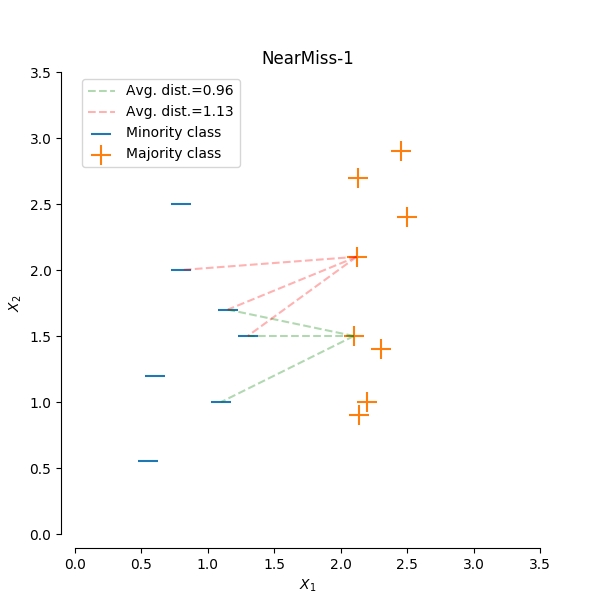

- `NearMiss-2`: selects majority class that are close to all minority class based on their avg distance to $N$ `n_neighbours(default=3)` farthest minority samples.
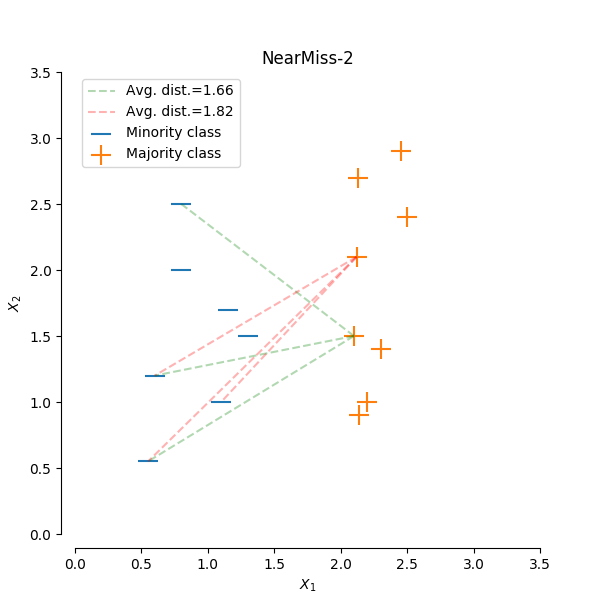

Poor performance might be due to: prescence of noise in the marginal outliers

- `NearMiss-3`: select a given number of closest minority for each majority instance. This method gurantees that every minority sample is surrounded by some majority samples.   

    1. For each minority instance, their $M$ `n_neighbours_ver3` nearest neighbours are kept.
    2. Majority samples with largest avg distance to the $N$ `n_neighbours(default=3)` are selected for undersampling.


Least affected by noise due to the first step sample selection
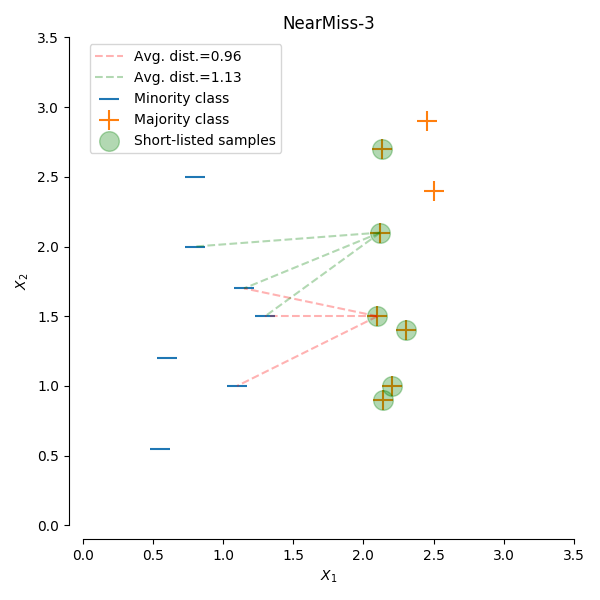

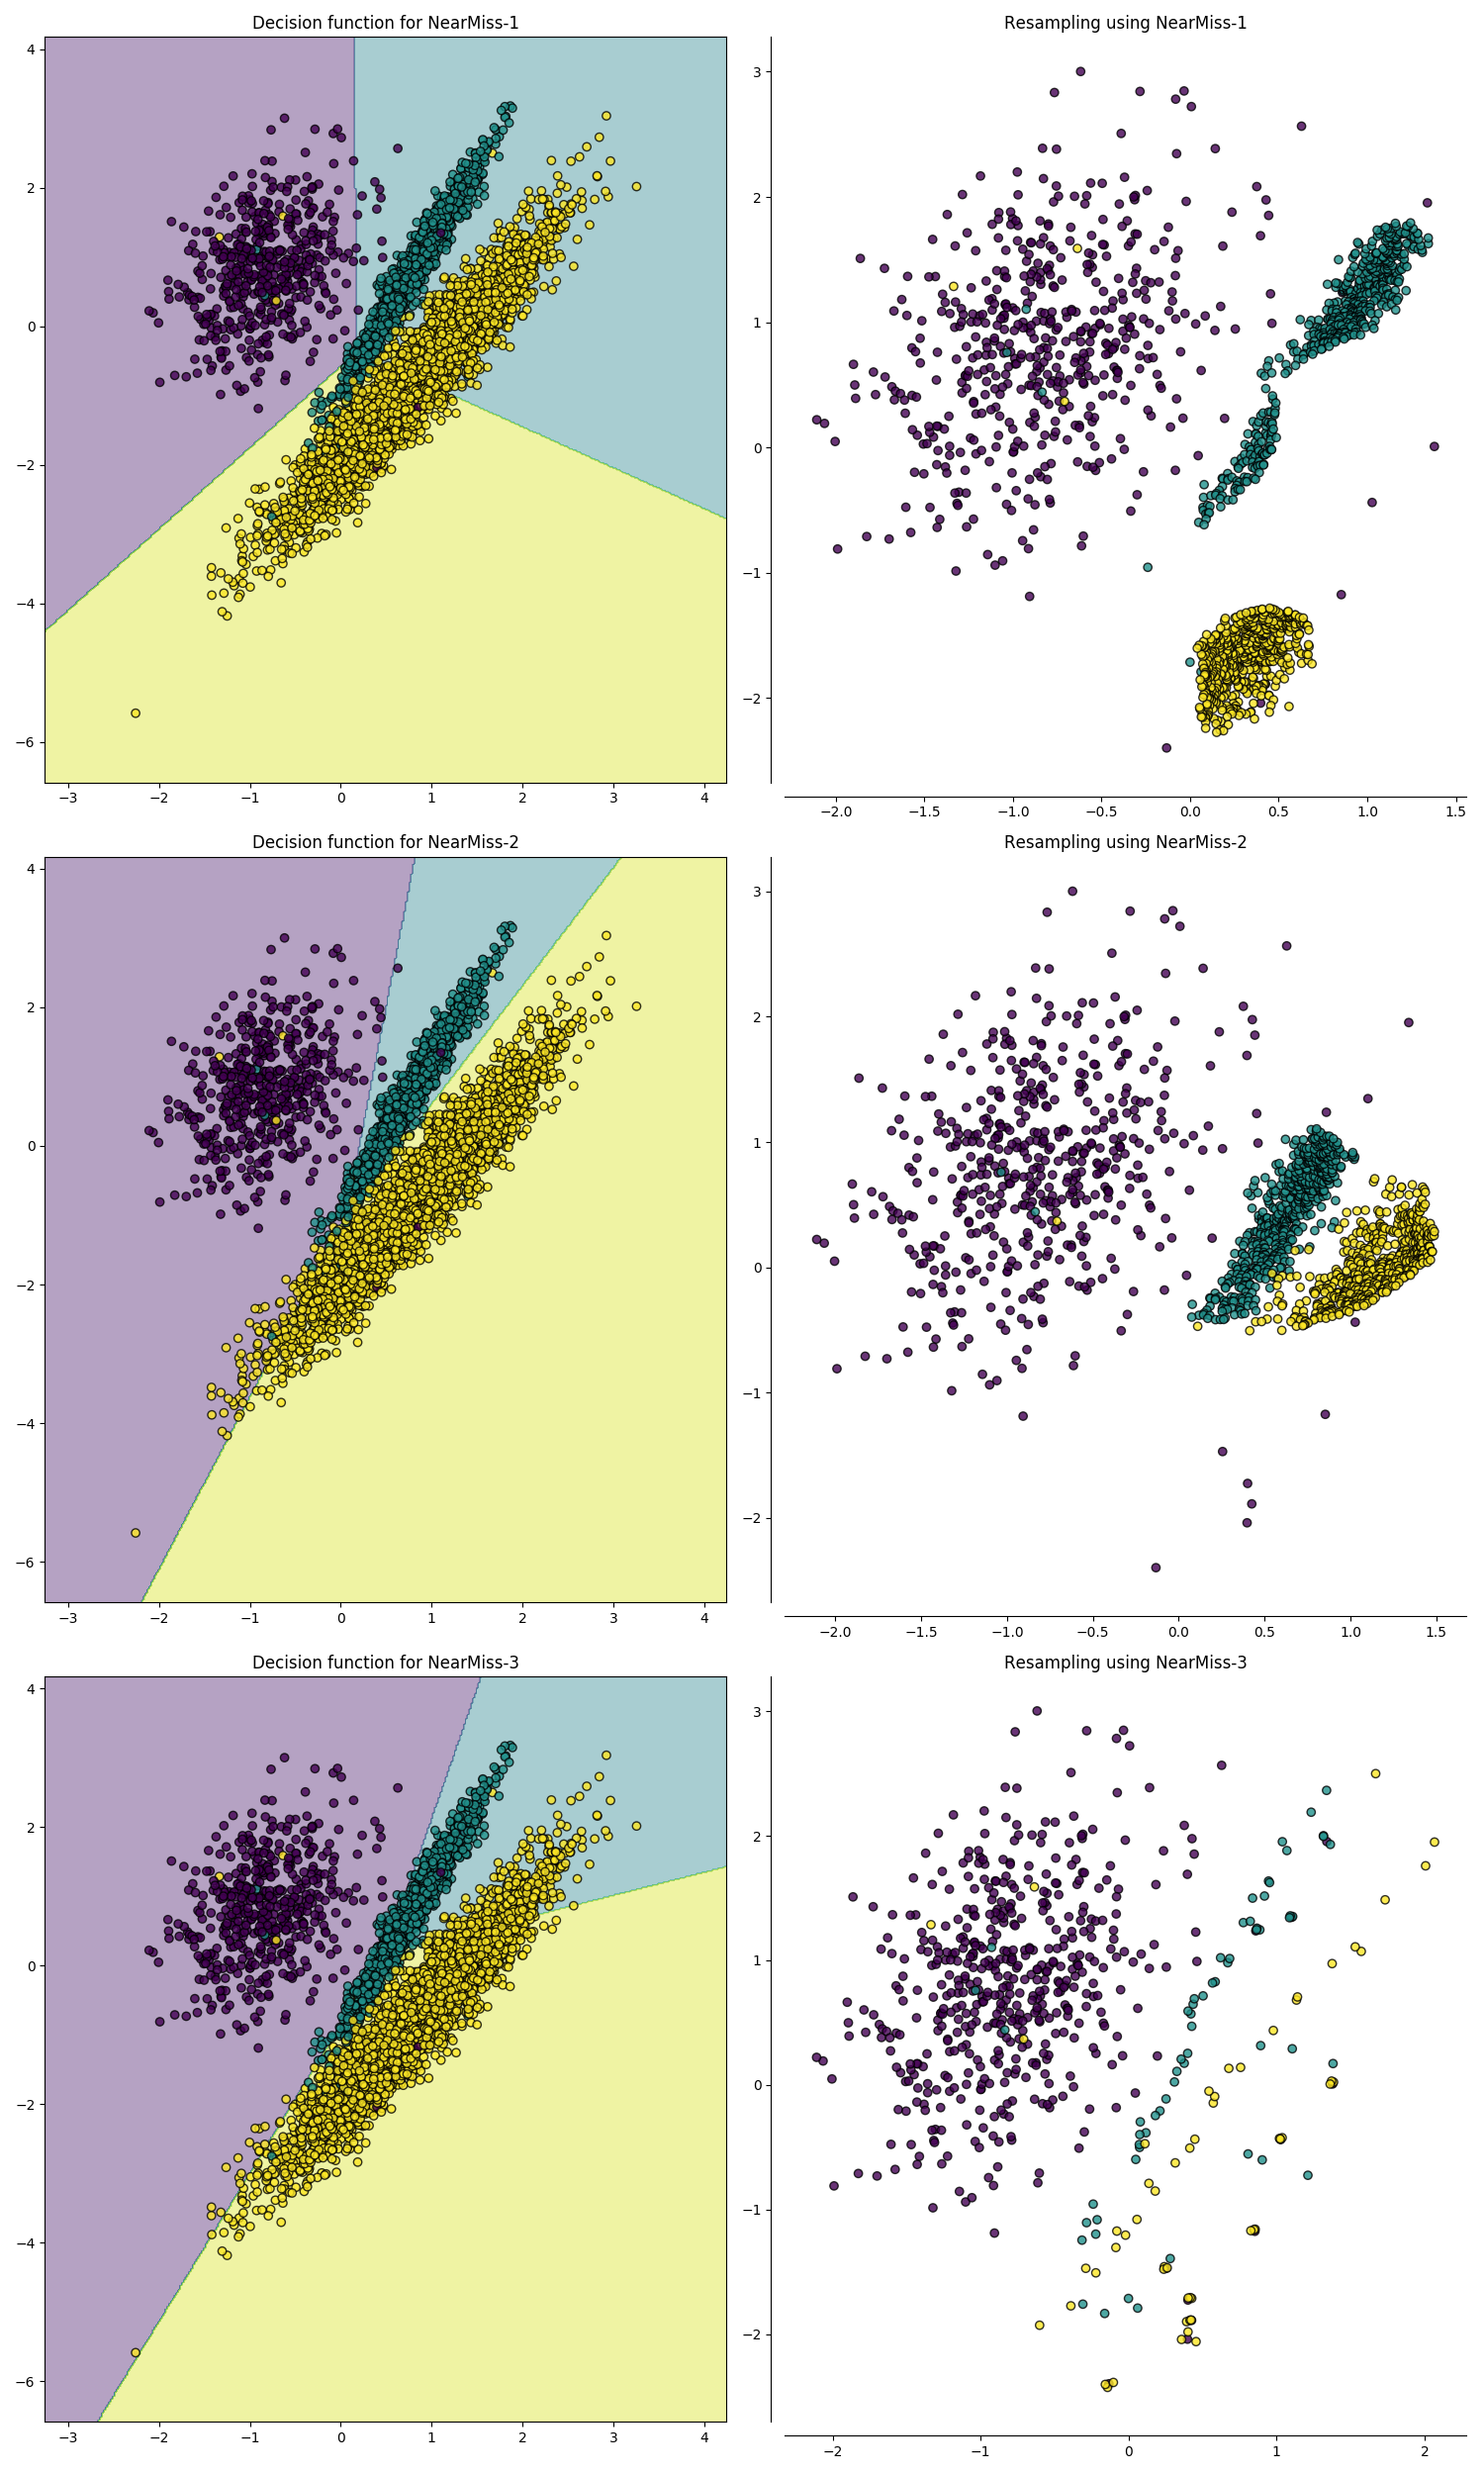

_Parameters_:

- `version`: version of NearMiss
- `n_neighbours`: size of neighbourhood to consider to compute the avg distance between minority point samples
- `n_neighbours_ver3`: M

#### Tomek
(Cleaning under-sampling techniques do not allow to specify the number of samples to have in each class.)

A Tomek’s link exist if the two samples are the nearest neighbors of each other. In the figure below, a Tomek’s link is illustrated by highlighting the samples of interest in green.

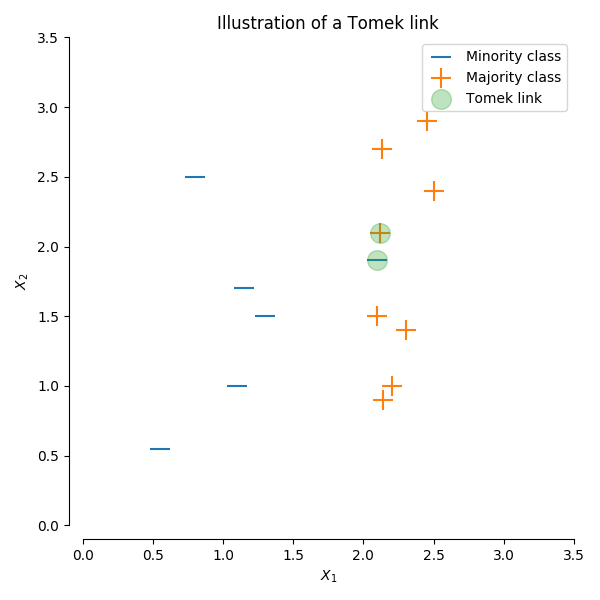

_Parameters_:

- `sampling_strategy`: controls which class of sample to be removed, similar to SMOTE

#### ENN :  Edited Nearest Neighbours

Removes majority instances whose class prediction made by KNN is difference from the class of >= 2/3 of its nearest neighbours. This usually removes the noisy/borderline examples to provide a smoother decision surface. ENN usually removes more samples than Tomek.

For each sample in the class to be under-sampled, the nearest-neighbours are computed and if the selection criterion is not fulfilled, the sample is removed. Selection via `kind_sel`.

_Parameters_:

- `kind_sel`: Strategy to use in order to exclude samples.

    - If 'all', all neighbours will have to agree with the samples of interest to not be excluded.
    - If 'mode', the majority vote of the neighbours will be used in order to exclude a sample.


Note: Removing from the borderline might not be ideal when problem statement aims to detect minority (e.g. rare cancer cases)


#### Repeated Nearest Neighbour

Extends ENN by repeating the ENN algorithm multiple times, thus deleting more data

_Parameters_:
- `max_iter`: Maximum number of iterations of the edited nearest neighbours algorithm for a single run.

#### ALLKNN

Differs from RENN as the number of neighbors of the internal nearest neighbors algorithm is increased at each iteration 

All 3 algo above gives pretty much the same results
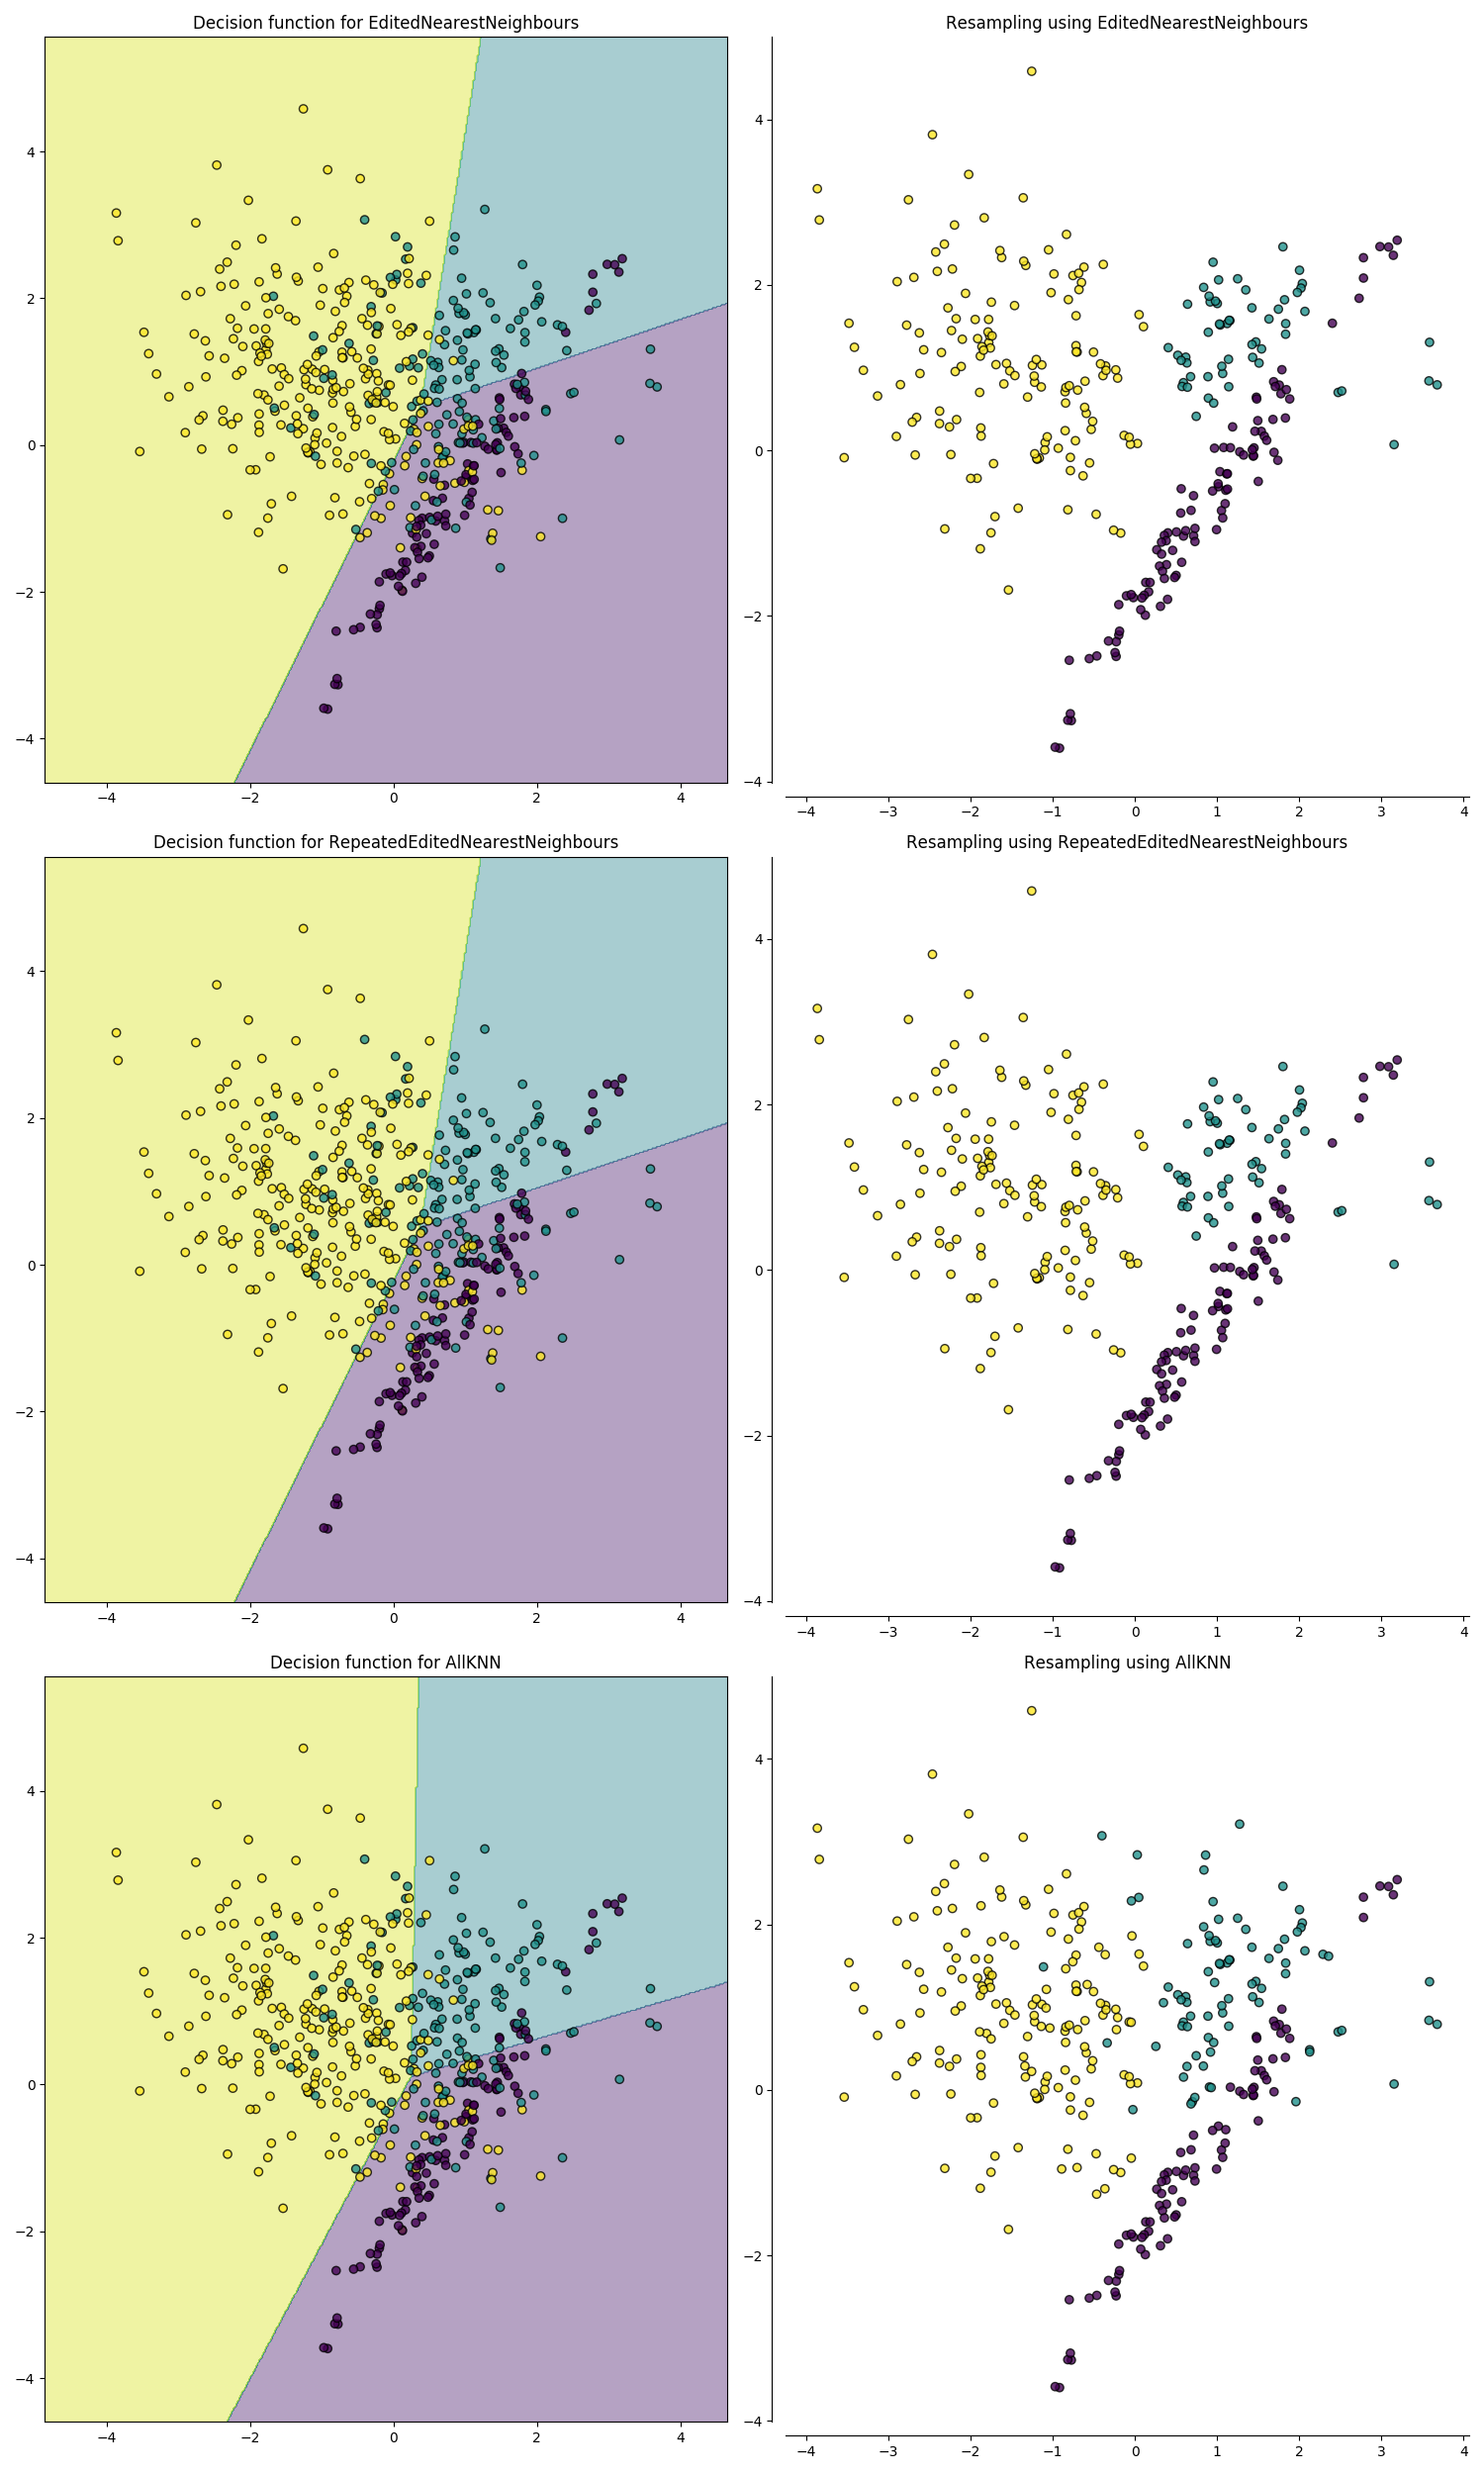

#### Condensed Nearest Neighbour 

Uses a 1NN rule to iteratively decides if a sample should be removed or not.

1. Get all minority samples in a set C.
2. Add a sample from the targeted class (class to be under-sampled) in C and all other samples of this class in a set S.
3. Go through the set S, sample by sample, and classify each sample using a 1 nearest neighbor rule.
4. If the sample is misclassified, add it to C, otherwise do nothing.
5. Reiterate on S until there is no samples to be added.
6. Set C is the dataset returned

Sensative to noise and will add noisy samples

#### One sided Selection

Use TomekLinks to remove noisy samples.

1. Apply 1NN on all samples
2. Add misclassified samples to C else do nothing
3. Set C is returned 


#### Neighbourhood Cleaning Rule

NCL uses ENN to remove majority examples.   
For each instance in the training set, it finds $N$ `(default=3)` nearest neighbors. 
- If the instance belongs to the majority class & $N$ nearest neighbors is the minority, then the chosen instance is removed. 
- If the chosen instance belongs to the minority class & its $N$ nearest neighbors are majority, then these neighbours are removed.

Results for all 3 algo above.
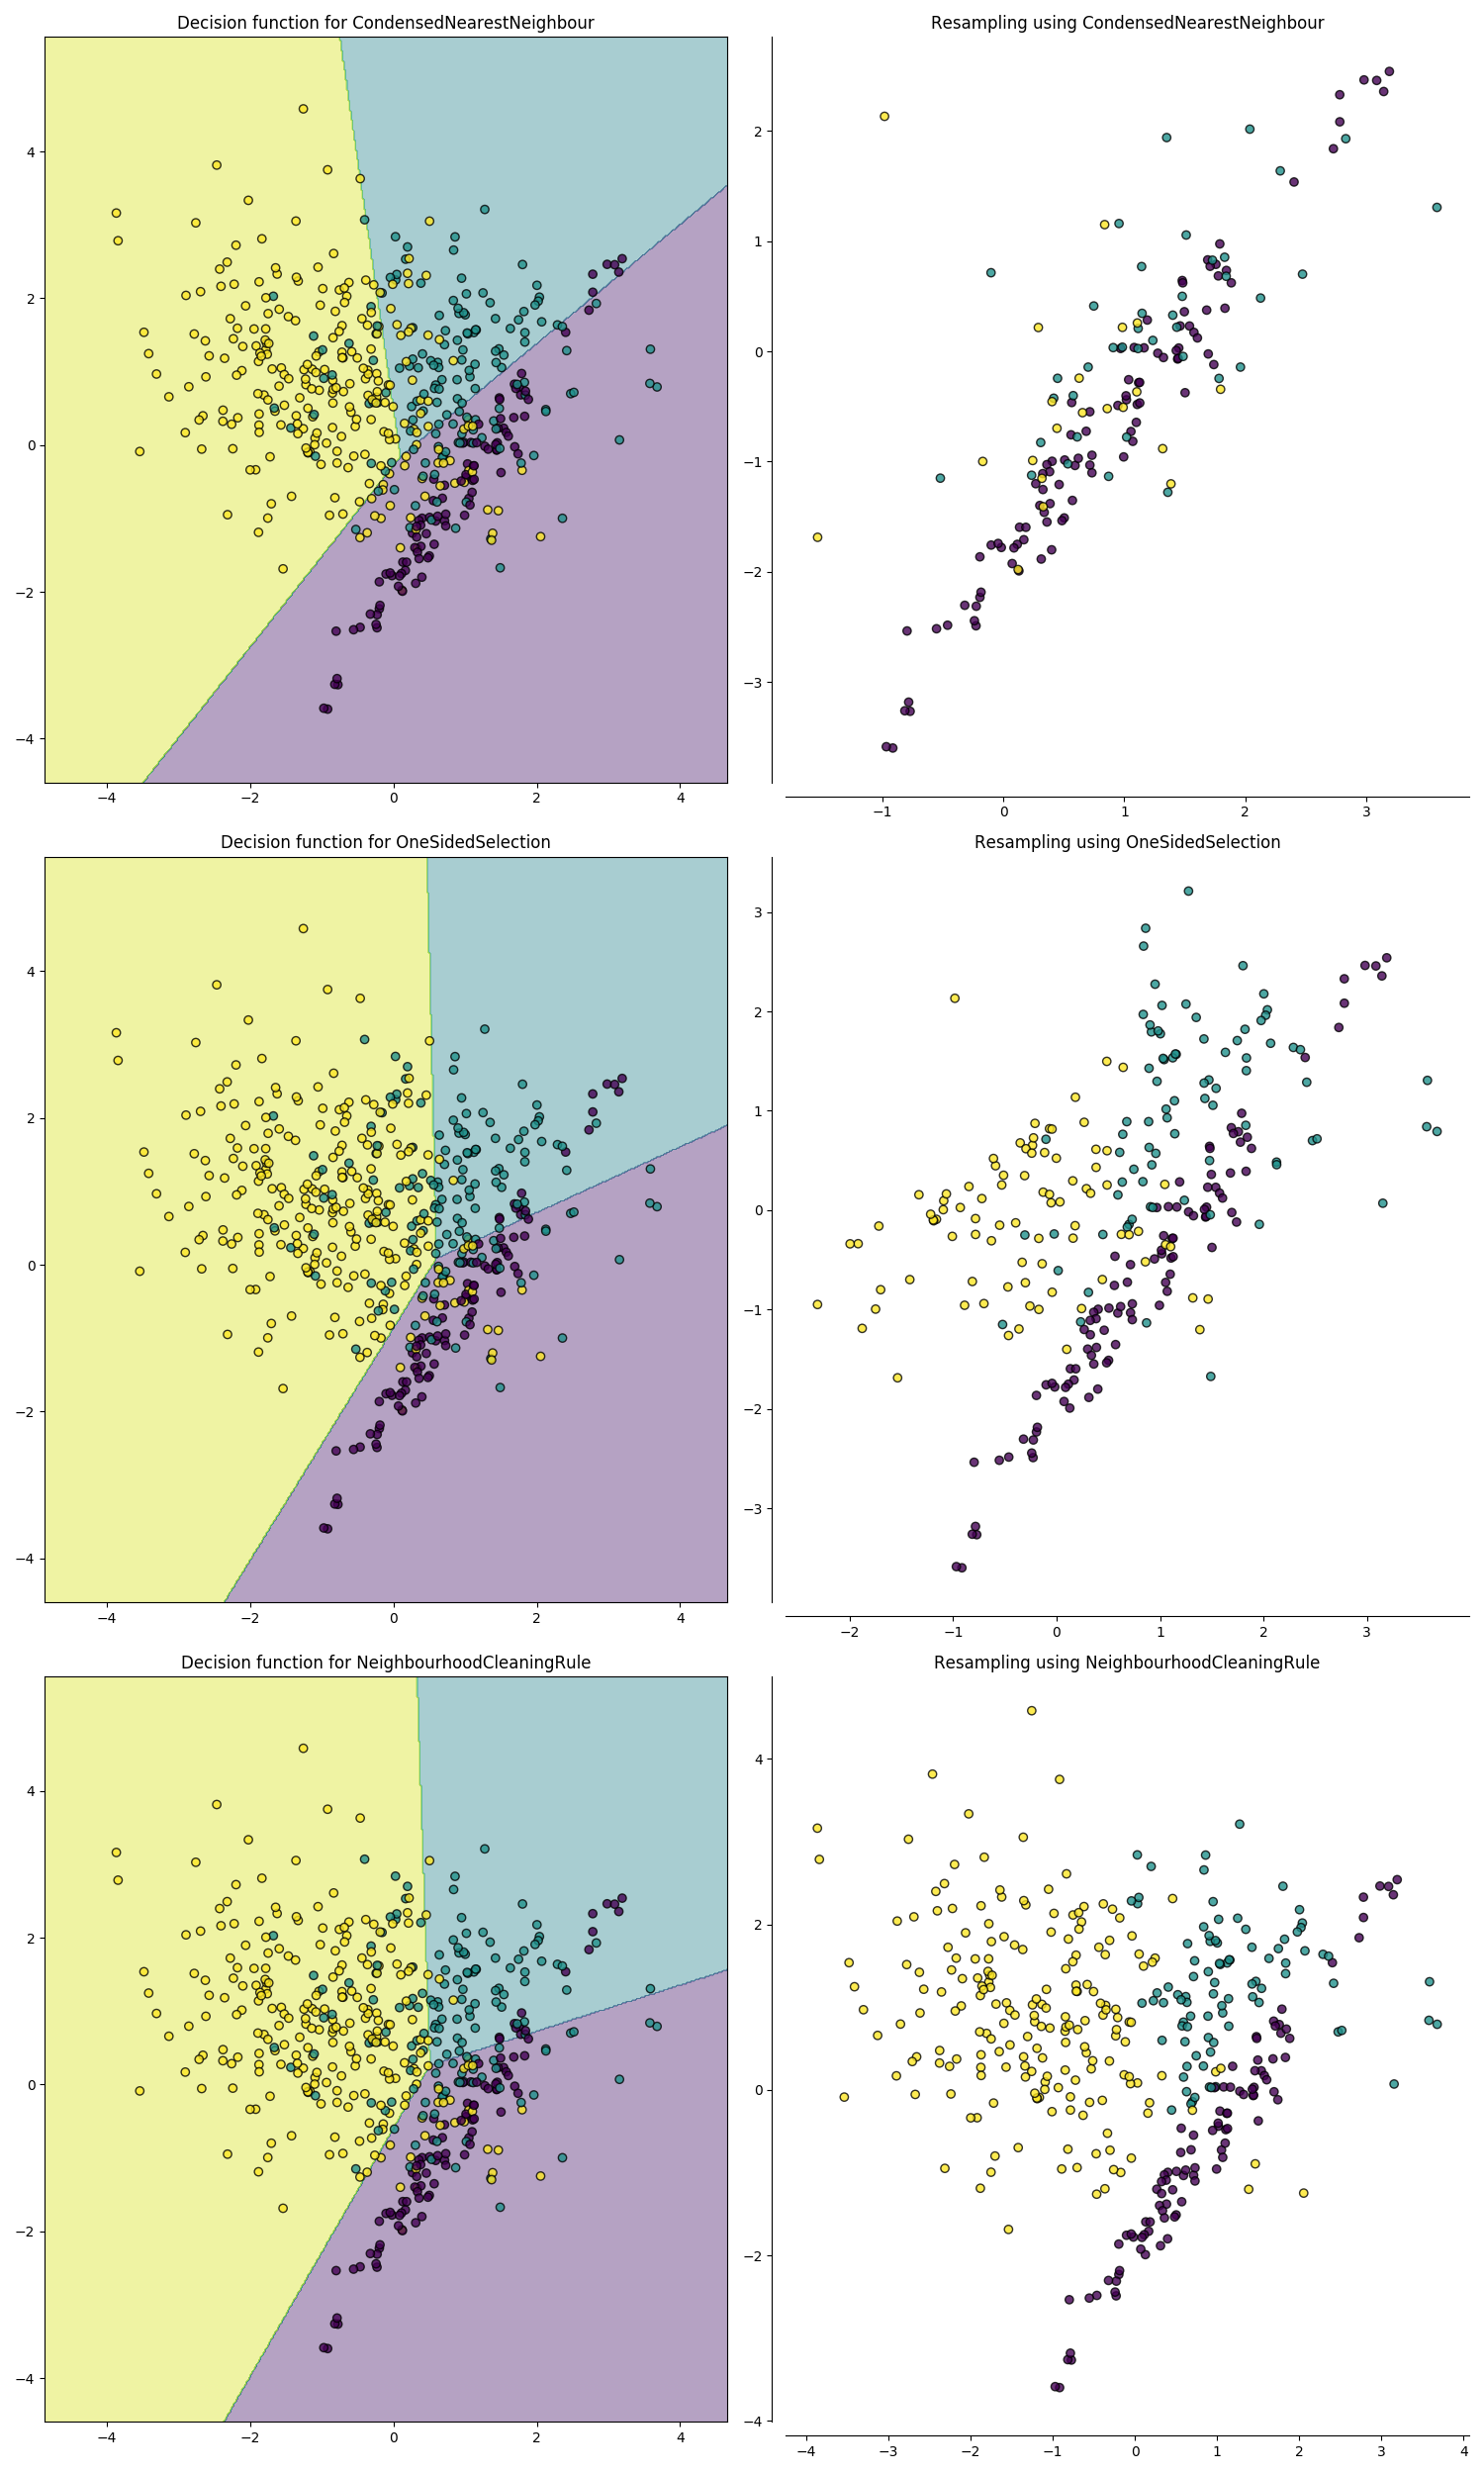

#### Instance hardness threshold

A classifier is trained on the data and samples with the lower probabilities are removed.

_Parameters_:
- `estimator`: accept any scikit-learn classifier with method `predict_proba`. 
- `cv`: the classifier training is performed using a cross-validation and the parameter cv can set the number of folds to use.

Note: May not be good when problem statement is to detect rare minority (e.g. rare cancer cases, etc)

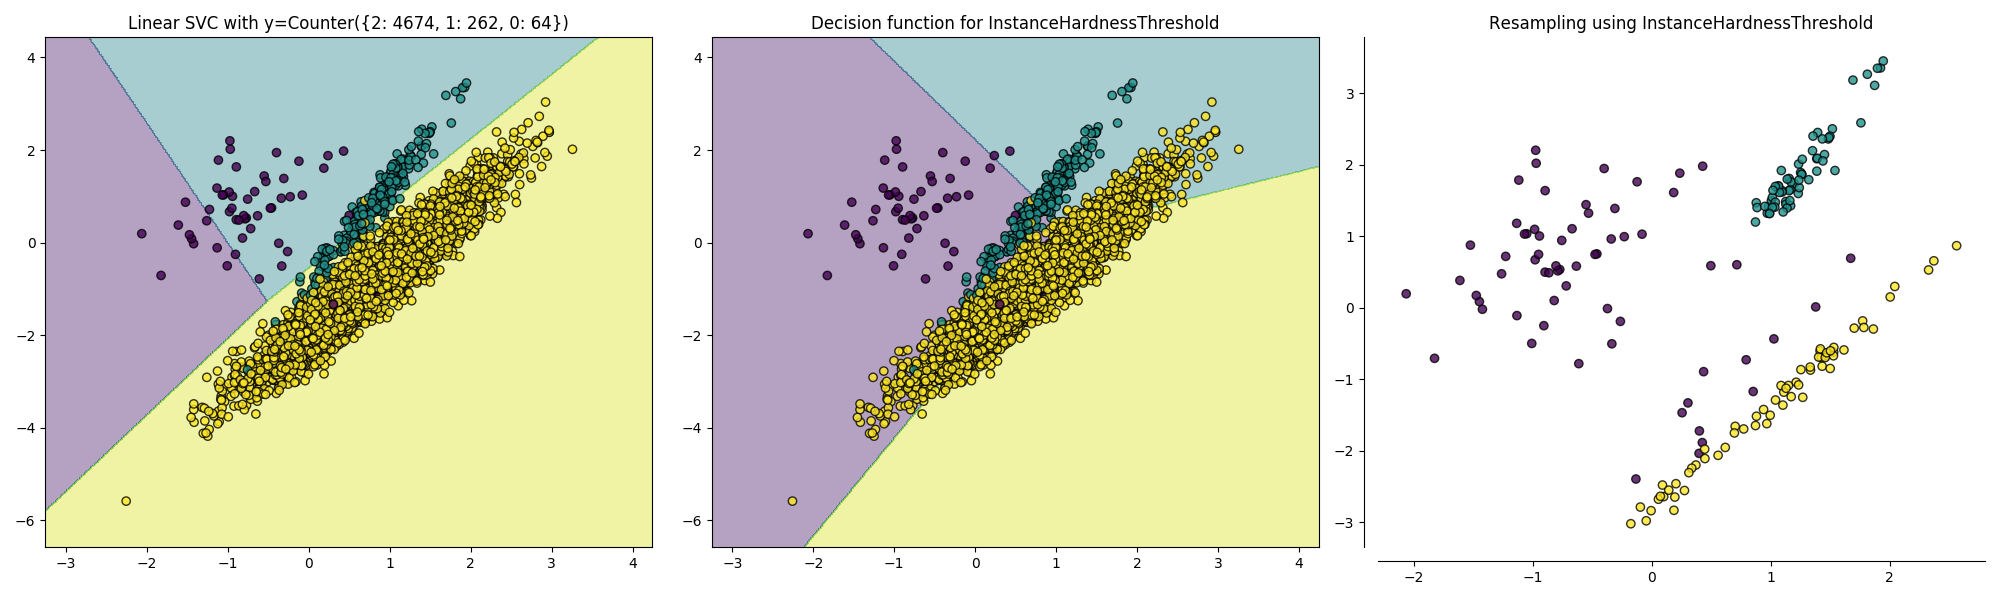

### Train-test split


__Always split BEFORE resampling (esp oversampling w replacement)__

In [14]:
# For different datasets
X = x_cc
Y = y_cc

In [15]:
# Original
x_train, x_test, y_train, y_test = train_test_split(X, Y, random_state=42)

In [16]:
# Resampled: Doing this is wrong as we want to resample only the train, not the test and train.
# Comparing the `sup` for this and that via pipeline and original shows the error
# X_rs, Y_rs = over_sampling.RandomOverSampler(random_state=42).fit_resample(X, Y)

# x_train_rs, x_test_rs, y_train_rs, y_test_rs = train_test_split(X_rs, Y_rs, random_state=42)

#### Train model

In [17]:
# Train classifier with original
clf = LogisticRegression(random_state=42).fit(x_train, y_train)
# Train classifier with resampling
# clf_rs = LinearSVC(random_state=42).fit(x_train_rs, y_train_rs)
# Train classifier with resampling via pipeline ROS
pl_ros.fit(x_train, y_train)

# Train classifier with resampling via pipeline SMOTE
pl_smote.fit(x_train, y_train)
# Train classifier with resampling via pipeline ADASYN
pl_adasyn.fit(x_train, y_train)

/home/juanchia/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/juanchia/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/juanchia/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/juanchia/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Pipeline(memory=None,
         steps=[('adasyn',
                 ADASYN(n_jobs=1, n_neighbors=5, random_state=42, ratio=None,
                        sampling_strategy='auto')),
                ('logisticregression',
                 LogisticRegression(C=1.0, class_weight=None, dual=False,
                                    fit_intercept=True, intercept_scaling=1,
                                    l1_ratio=None, max_iter=100,
                                    multi_class='warn', n_jobs=None,
                                    penalty='l2', random_state=42,
                                    solver='warn', tol=0.0001, verbose=0,
                                    warm_start=False))],
         verbose=False)

#### Optimize model with cost:

Suppose the cost of false positive is 50.


In [80]:
def costed_error(y, y_hat):
    sum_error = 0
    for _y, _y_hat in zip(y, y_hat):
        if _y != _y_hat:
            n = 1 if _y == 0 else 50
            sum_error += n
    return sum_error

In [81]:
# Original
costed_error(y_test, clf.predict(x_test))

2312

In [82]:
# ROS
costed_error(y_test, pl_ros.predict(x_test))

2201

In [83]:
# SMOTE
costed_error(y_test, pl_smote.predict(x_test))

1191

In [84]:
# ADASYN
costed_error(y_test, pl_adasyn.predict(x_test))

4048

In [87]:
cost_lst = pd.DataFrame({'cost':[2312,2201,1191,4048], 'models':['original', 'ROS', 'SMOTE', 'ADASYN']})

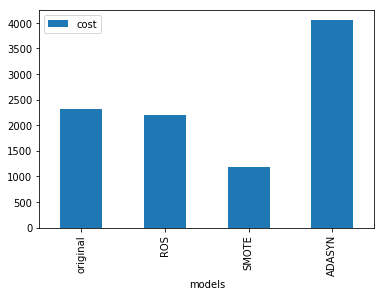

In [92]:
cost_lst.plot(kind='bar', x='models', y='cost')

#### Optimize model with learning curve:

Checking the optimal number of samples needed for each class to achieve a good F1-score

In [1]:
from sklearn.metrics import f1_score

In [79]:
Counter(y_test)

Counter({0: 71089, 1: 113})

In [76]:
def learning_curve(X, y, x_test, y_test, observations=range(1,379)):
    scores = []
    for n in observations:
        rus = under_sampling.RandomUnderSampler(random_state=0, ratio={0: n, 1: n})
        rus.fit(X, y)
        X_resampled, y_resampled = rus.fit_resample(X, y)
        model = LogisticRegression(random_state=42, solver='liblinear', multi_class='auto', max_iter=200).fit(X_resampled, y_resampled)
        pred = model.predict(x_test)
        scores.append(f1_score(y_test, pred))
    return scores

Text(0,0.5,'F1-Score')

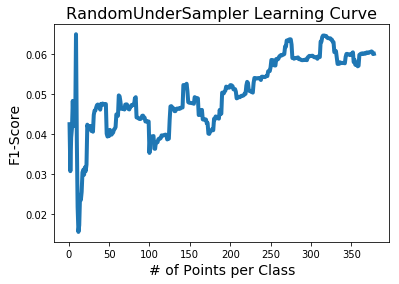

In [77]:
plt.plot(range(1,379), learning_curve(x_train, y_train, x_test, y_test), linewidth=4)
plt.title("RandomUnderSampler Learning Curve", fontsize=16)
plt.gca().set_xlabel("# of Points per Class", fontsize=14)
plt.gca().set_ylabel("F1-Score", fontsize=14)

Strange spike in F1-score at near 0 points per class. (To investigate)

Performance of model stabalize around 315 observations per class. This means that the ROS wont introduce significant variance to the model by having too few points.

#### Evaluation

In [15]:
# Evaluate original and resampled
from imblearn.metrics import classification_report_imbalanced

In [ ]:
# Learning curve via cost-metrics


In [ ]:
# Original
print("Original")
print(classification_report_imbalanced(y_test, clf.predict(x_test)))

# Resampled
print('Resampled')
print(classification_report_imbalanced(y_test_rs, clf_rs.predict(x_test_rs)))

# Resampled via pipeline ROS
print(classification_report_imbalanced(y_test, pl_ros.predict(x_test)))

In [ ]:
# Resampled via pipeline SMOTE
print(classification_report_imbalanced(y_test, pl_smote.predict(x_test)))

In [ ]:
# Resampled via pipeline ADASYN
print(classification_report_imbalanced(y_test, pl_adasyn.predict(x_test)))

#### Ploting Precision-Recall  & ROC curves

In [23]:
from sklearn.metrics import classification_report,confusion_matrix,roc_curve,auc,precision_recall_curve,roc_curve

from sklearn.calibration import CalibratedClassifierCV

In [ ]:
# LinearSVC
# Ploting Precision-Recall & ROC curves

lr_model = CalibratedClassifierCV(base_estimator=LinearSVC(random_state=42), cv=5)
lr_model.fit(x_train_rs, y_train_rs)
res = lr_model.predict_proba(x_test_rs)[:, 1]

# pr, roc curves
p,r,_ = precision_recall_curve(y_test_rs, res)
tpr,fpr,_ = roc_curve(y_test_rs, res)

# https://www.kaggle.com/lct14558/imbalanced-data-why-you-should-not-use-roc-curve
fig = plt.figure(figsize=(15,8))
ax1 = fig.add_subplot(1,2,1)
ax1.set_xlim([-0.05,1.05])
ax1.set_ylim([-0.05,1.05])
ax1.set_xlabel('Recall')
ax1.set_ylabel('Precision')
ax1.set_title('PR Curve')

ax2 = fig.add_subplot(1,2,2)
ax2.set_xlim([-0.05,1.05])
ax2.set_ylim([-0.05,1.05])
ax2.set_xlabel('False Positive Rate')
ax2.set_ylabel('True Positive Rate')
ax2.set_title('ROC Curve')

ax1.plot(r,p,c='b')
ax2.plot(tpr,fpr,c='r')

plt.show()

/home/juanchia/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/juanchia/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/juanchia/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/juanchia/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


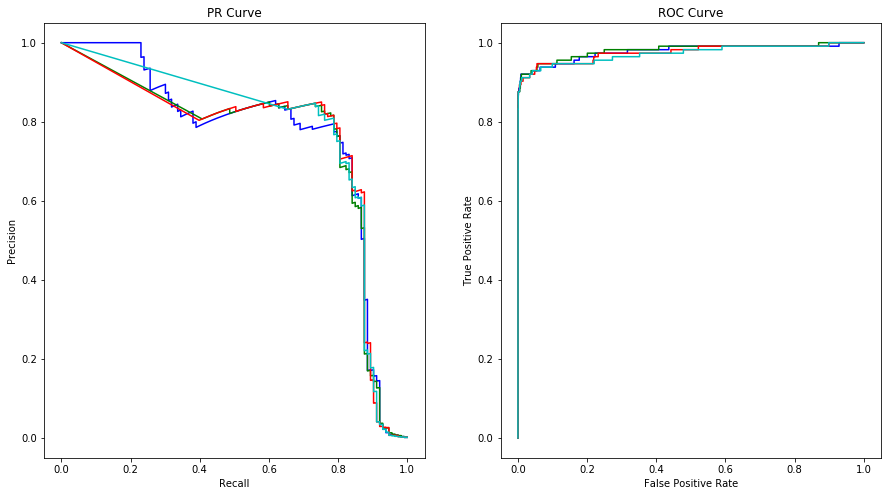

In [28]:
# LogReg: Original, ROS, SMOTE, ADASYN
# https://www.kaggle.com/lct14558/imbalanced-data-why-you-should-not-use-roc-curve
fig = plt.figure(figsize=(15,8))
ax1 = fig.add_subplot(1,2,1)
ax1.set_xlim([-0.05,1.05])
ax1.set_ylim([-0.05,1.05])
ax1.set_xlabel('Recall')
ax1.set_ylabel('Precision')
ax1.set_title('PR Curve')

ax2 = fig.add_subplot(1,2,2)
ax2.set_xlim([-0.05,1.05])
ax2.set_ylim([-0.05,1.05])
ax2.set_xlabel('False Positive Rate')
ax2.set_ylabel('True Positive Rate')
ax2.set_title('ROC Curve')

# Ploting PR & ROC curves
for model, colour in zip([clf, pl_ros, pl_smote, pl_adasyn],
                             'bgrk'):
    lr_model = model
    lr_model.fit(x_train,y_train)
    pred_prob = lr_model.predict_proba(x_test)[:,1]

    p,r,_ = precision_recall_curve(y_test,pred_prob)
    tpr,fpr,_ = roc_curve(y_test,pred_prob)
    
    ax1.plot(r,p,c=colour)
    ax2.plot(tpr,fpr,c=colour)
    
# ax1.legend(loc='lower left')    
# ax2.legend(loc='lower left')

plt.show()

For a PR curve, a good classifer aims for the upper right corner of the chart but upper left for the ROC curve.

While PR and ROC curves use the same data, i.e. the real class labels and predicted probability for the class lables, you can see that the two charts tell very different stories, with some weights seem to perform better in ROC than in the PR curve.

While the Original model (blue) perform well in the ROC curve, it gives suboptimal performance in recall. Precision drops drastically when recall increases.

Depending on our business objectives, if we want to optimize for recall, the SMOTE model (red) would be selected as it gives us the highest precision for recall.

Because TPR only depends on positives, ROC curves do not measure the effects of negatives. The area under the ROC curve (AUC) assesses overall classification performance. AUC does not place more emphasis on one class over the other, so it does not reflect the minority class well.

Davis and Goadrich in this paper propose that Precision-Recall (PR) curves will be more informative than ROC when dealing with highly skewed datasets. The PR curves plot precision vs. recall (FPR). Because Precision is directly influenced by class imbalance so the Precision-recall curves are better to highlight differences between models for highly imbalanced data sets. When you compare different models with imbalanced settings, the area under the Precision-Recall curve will be more sensitive than the area under the ROC curve.


In [ ]:
# Illustrate imbalance dataset

In [ ]:
# Plotting
import matplotlib.pyplot as plt
import numpy as np

def plot_decision_function(X, y, clf, ax):
    plot_step = 0.02
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1:3].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, plot_step),
                         np.arange(y_min, y_max, plot_step))

    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    ax.contourf(xx, yy, Z, alpha=0.4)
    ax.scatter(X[:, 0], X[:, 1], alpha=0.8, c=y, edgecolor='k')

In [ ]:
fig, ax1 = plt.subplots(1,2, figsize=(15, 7))

In [ ]:
clf = LinearSVC().fit(X, Y)

In [ ]:
plot_decision_function(X, Y, clf, ax1)

In [ ]:
from sklearn.datasets import make_classification
def create_dataset(n_samples=1000, weights=(0.01, 0.01, 0.98), n_classes=3,
                   class_sep=0.8, n_clusters=1):
    return make_classification(n_samples=n_samples, n_features=2,
                               n_informative=2, n_redundant=0, n_repeated=0,
                               n_classes=n_classes,
                               n_clusters_per_class=n_clusters,
                               weights=list(weights),
                               class_sep=class_sep, random_state=0)

In [ ]:
X1, y1 = create_dataset(n_samples=5000, weights=(0.01, 0.05, 0.94),
                      class_sep=0.8)

In [ ]:
X = X1
y = y1

In [ ]:
clf = LinearSVC().fit(X, y)

In [ ]:
xx

In [ ]:
yy

In [ ]:
np.c_[xx.ravel(), yy.ravel()]

In [ ]:
# def plot_decision_function(X, y, clf, ax):
plot_step = 0.02
x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
y_min, y_max = X[:, 1:3].min() - 1, X[:, 1:3].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, plot_step),
                     np.arange(y_min, y_max, plot_step))

In [ ]:
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    ax.contourf(xx, yy, Z, alpha=0.4)
    ax.scatter(X[:, 0], X[:, 1], alpha=0.8, c=y, edgecolor='k')

In [ ]:
plot_decision_function(X, y, clf, ax1)

In [ ]:
from collections import Counter

from sklearn.datasets import load_iris
from sklearn.svm import LinearSVC
from sklearn.model_selection import train_test_split

from imblearn.datasets import make_imbalance
from imblearn.under_sampling import NearMiss
from imblearn.pipeline import make_pipeline
from imblearn.metrics import classification_report_imbalanced

print(__doc__)

RANDOM_STATE = 42

# Create a folder to fetch the dataset
iris = load_iris()
X, y = make_imbalance(iris.data, iris.target,
                      sampling_strategy={0: 25, 1: 50, 2: 50},
                      random_state=RANDOM_STATE)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, random_state=RANDOM_STATE)

print('Training target statistics: {}'.format(Counter(y_train)))
print('Testing target statistics: {}'.format(Counter(y_test)))

# Create a pipeline
pipeline = make_pipeline(NearMiss(version=2),
                         LinearSVC(random_state=RANDOM_STATE))
pipeline.fit(X_train, y_train)

# Classify and report the results
print(classification_report_imbalanced(y_test, pipeline.predict(X_test)))